In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, from_json, substring, when, length, split, lit
from pyspark.sql.types import StructType, StructField, StringType
from pyspark import StorageLevel

In [6]:
# Nomes de aquivos e pastas
csv_pj = 'dataset/empresas_estabelecimentos_1m.csv'
parquet_dir_name = 'output/embeddings_nome_1m'
investigaCEP='13560'

In [3]:
spark = SparkSession.builder \
        .config("spark.driver.memory", "128g") \
        .appName("gera_embedding_nome") \
        .getOrCreate()

23/12/08 17:10:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Schema para Json Empresa
json_schema_em = StructType([
    StructField("porteEmpresa", StringType(), True),
    StructField("capitalSocial", StringType(), True),
    StructField("cpfResponsavel", StringType(), True),
    StructField("nomeEmpresarial", StringType(), True),
    StructField("naturezaJuridica", StringType(), True),
    StructField("qualificacaoResponsavel", StringType(), True)
])

# Schema para Json Estabelecimento
json_schema_es = StructType([
    StructField("uf", StringType(), True),
    StructField("cep", StringType(), True),
    StructField("ddd1", StringType(), True),
    StructField("ddd2", StringType(), True),
    StructField("pais", StringType(), True),
    StructField("email", StringType(), True),
    StructField("bairro", StringType(), True),
    StructField("numero", StringType(), True),
    StructField("municipio", StringType(), True),
    StructField("telefone1", StringType(), True),
    StructField("telefone2", StringType(), True),
    StructField("cnaeFiscal", StringType(), True),
    StructField("logradouro", StringType(), True),
    StructField("complemento", StringType(), True),
    StructField("dataCadastro", StringType(), True),
    StructField("nomeFantasia", StringType(), True),
    StructField("cidadeExterior", StringType(), True),
    StructField("tipoLogradouro", StringType(), True),
    StructField("cnaesSecundarias", StringType(), True),
    StructField("situacaoEspecial", StringType(), True),
    StructField("situacaoCadastral", StringType(), True),
    StructField("dataSituacaoEspecial", StringType(), True),
    StructField("dataSituacaoCadastral", StringType(), True),
    StructField("motivoSituacaoCadastral", StringType(), True),
    StructField("identificadorMatrizFilial", StringType(), True)
])

# Definindo o esquema para leitura do CSV
schema = StructType([
    StructField("nu_cnpj_raiz", StringType(), True),
    StructField("te_dados_em", StringType(), True),
    StructField("id_estabelecimento", StringType(), True),
    StructField("te_dados_es", StringType(), True)
])

# Lendo o CSV com o esquema definido
pj = spark.read \
    .option("delimiter", ",") \
    .option("multiline", "true") \
    .option("escape", "\"") \
    .csv(csv_pj, schema=schema, header=True)

pj = pj.withColumn("te_dados_em", from_json(col("te_dados_em"), json_schema_em)) \
      .withColumn("te_dados_es", from_json(col("te_dados_es"), json_schema_es)) \
      .filter(substring(col("id_estabelecimento"), 0, 4) == '0001') \
      .withColumnRenamed("nu_cnpj_raiz", "id")

pj = pj.orderBy(col("id").asc()).dropDuplicates(['id'])

In [5]:
# Carrega embeddings
nomes_pj = spark.read.parquet(parquet_dir_name)

In [14]:
cnpjs_filtrados = pj \
    .filter(col("te_dados_es.cep").startswith(investigaCEP)) \
    .filter(col("te_dados_es.situacaoCadastral") == '02') \
    .select(col("id"))

# Filtrando 'nomes_pj' com base nos CNPJs filtrados
nomes_filtrados = nomes_pj.join(cnpjs_filtrados, nomes_pj["id"] == pj["id"], "inner") \
                          .select(nomes_pj["id"], nomes_pj["nomeFantasia"],  nomes_pj["embeddings"])
nomes_filtrados.persist(StorageLevel.MEMORY_AND_DISK)
nomes_filtrados.show()

+--------+--------------------+--------------------+
|      id|        nomeFantasia|          embeddings|
+--------+--------------------+--------------------+
|03972238|             FUTURIA|[0.07478653, 0.32...|
|03721558|            DI GASPI|[-0.1226381, 0.20...|
|03729244|         C F C PATUM|[-0.07220966, 0.0...|
|03561528|ALFA IMOVEIS SAO ...|[-0.036208127, 0....|
|03562381|        GHANDI SECAF|[-0.14631335, 0.3...|
|03991159|                 3WT|[0.33141822, -0.2...|
|03991594|DEIENNO E FERRAZ ...|[-0.12413079, 0.1...|
|04002857|     AQUARELA TINTAS|[-0.015137672, -0...|
|04003540|COMERCIAL NOVA GE...|[0.002041091, 0.0...|
|03518530|   RELOJOARIA SUISSA|[0.15033743, -0.0...|
|04093078|    SISTEMA SERVICOS|[-0.17938979, -0....|
|03745321|     CRIANCA ARTEIRA|[0.051747646, -0....|
|03756907|        EURO IDIOMAS|[-0.1323092, 0.09...|
|03758184|              LANA'S|[-0.0386058, -0.2...|
|03578313| AVALIACAO CAMISETAS|[0.07126883, -0.0...|
|03567802|               VERBO|[0.211128, 0.00

In [15]:
print(nomes_filtrados.count())

27


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Converter os embeddings para um formato compatível com o cosine_similarity
embeddings = np.array(nomes_filtrados.select("embeddings").collect())
embeddings =  np.vstack(embeddings)
# print(embeddings)
# Calcular a matriz de similaridade usando cosine_similarity
matriz_similaridade = cosine_similarity(embeddings, embeddings)

# Imprimir a matriz de similaridade
print(matriz_similaridade)

[[ 1.          0.63830178  0.33121197  0.41418471  0.55043923  0.42037281
   0.46366204  0.44814491  0.56184434  0.60643616  0.38295509  0.58856781
   0.3513128   0.59828593  0.60381072  0.66343167  0.37965942  0.42675753
   0.66712712  0.6839123   0.12074141  0.32528407  0.28533634  0.18841135
   0.36029423  0.66880226  0.11978197]
 [ 0.63830178  1.          0.40250034  0.53675106  0.54328778  0.40655197
   0.55690151  0.51981418  0.5932703   0.59689382  0.4275005   0.64424239
   0.35394731  0.55956338  0.66840357  0.62928907  0.73744073  0.53646216
   0.65847956  0.78252689  0.26705807  0.43314385  0.45659127  0.22436916
   0.38601003  0.62995559  0.14185768]
 [ 0.33121197  0.40250034  1.          0.29235817  0.32632928  0.31032027
   0.39913941  0.42853689  0.40528827  0.32495192  0.31851793  0.40839061
   0.25990658  0.3332358   0.46348693  0.34058921  0.35803962  0.39733986
   0.40006131  0.44109944  0.09555294  0.4179663   0.38513646  0.15294017
   0.28457617  0.44340227  0.17219

In [17]:
inter_x = 0
inter_y = 27
nova_matriz_similaridade = matriz_similaridade[inter_x:inter_y, inter_x:inter_y]

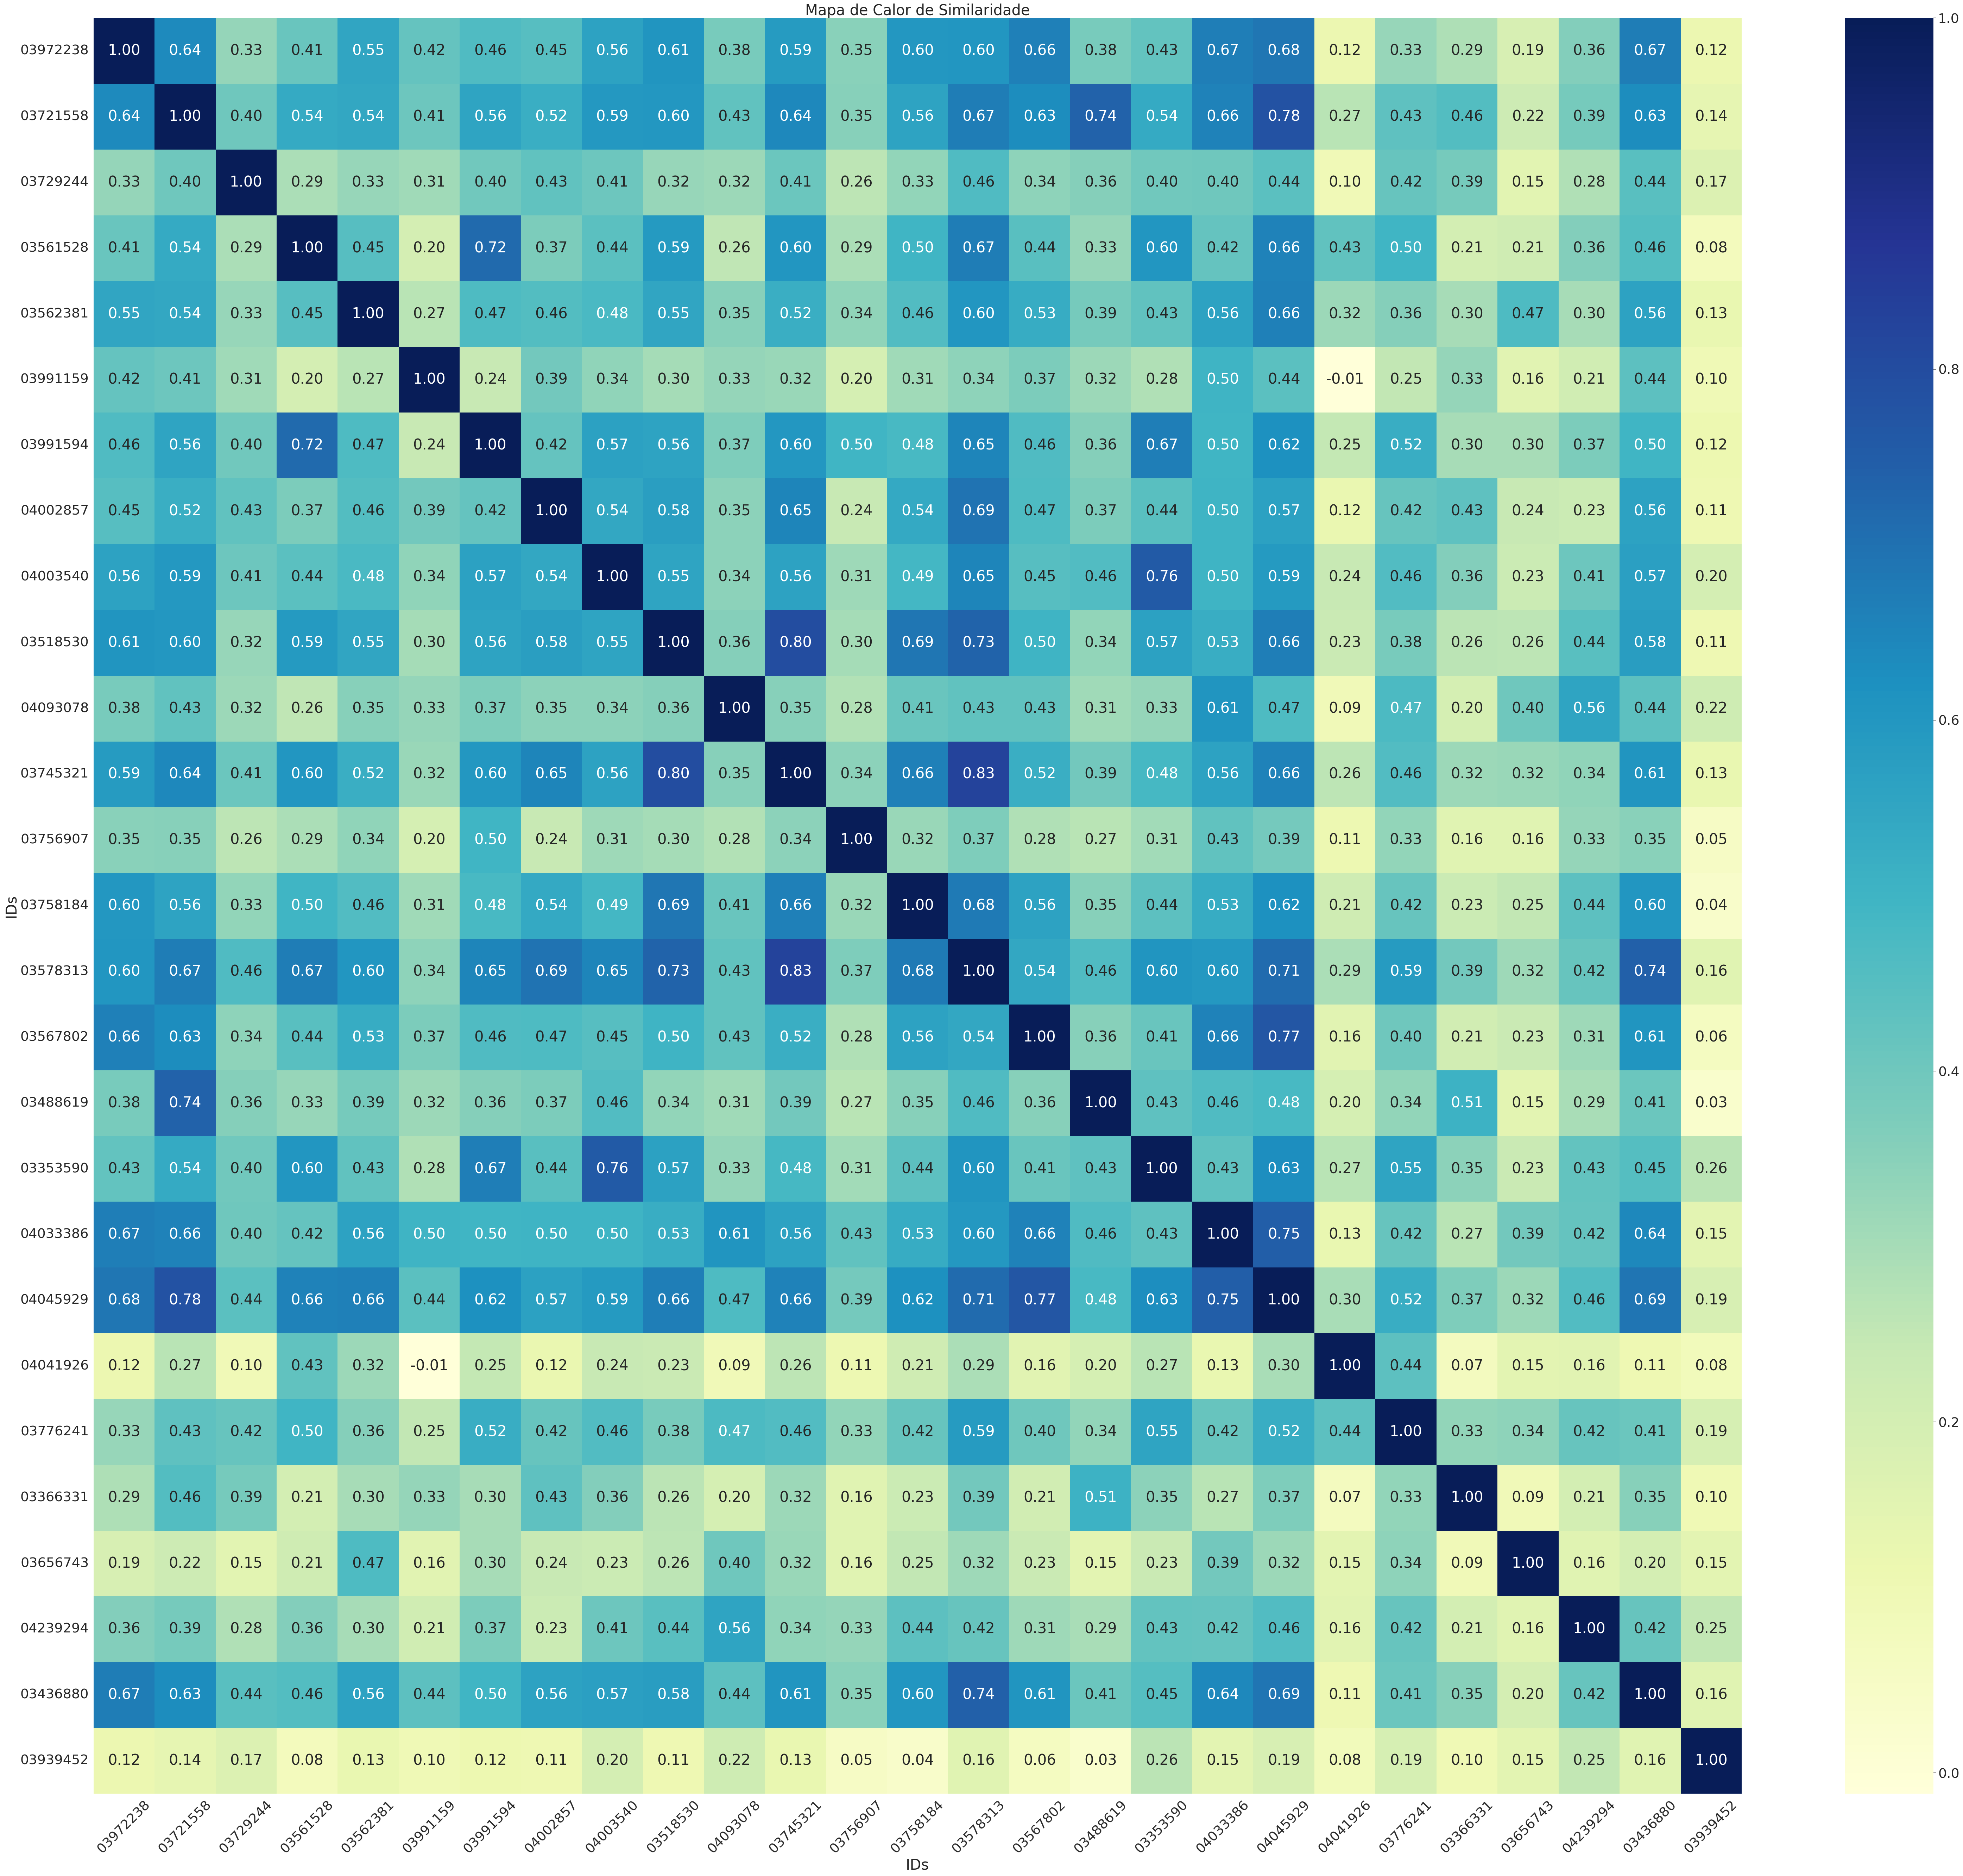

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtendo os IDs dos nomes filtrados
ids = nomes_filtrados.select("id").rdd.flatMap(lambda x: x).collect()[inter_x:inter_y]

# Plotando o mapa de calor da matriz de similaridade
sns.set(style="white")  # Configuração do estilo do plot
plt.figure(figsize=(62, 54))  # Definindo o tamanho da figura

# Criando o mapa de calor
sns.set(font_scale=2.5)
ax = sns.heatmap(nova_matriz_similaridade, annot=True, fmt=".2f", xticklabels=ids, yticklabels=ids, cmap="YlGnBu")

# Configurações adicionais
plt.title('Mapa de Calor de Similaridade')
plt.xlabel('IDs')
plt.ylabel('IDs')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrando o mapa de calor
plt.show()

In [19]:
import numpy as np
n = 27
# Criar uma máscara para a diagonal e abaixo dela
mask = np.triu(np.ones(matriz_similaridade.shape), k=1).astype(bool)

# Aplicar a máscara para ignorar a diagonal e valores abaixo dela
valores_acima_diagonal = matriz_similaridade[mask]

# Encontrar os índices dos n maiores valores acima da diagonal
indices_maior_valor = np.argsort(valores_acima_diagonal)[-n:][::-1]

# Obter os valores e suas coordenadas na matriz de similaridade
valores_maior_valor = valores_acima_diagonal[indices_maior_valor]
coordenadas = np.argwhere(mask)

# Imprimir os n maiores valores e suas coordenadas acima da diagonal
for i in range(n):
    idx = coordenadas[indices_maior_valor[i]]
    print(f"Valor: {valores_maior_valor[i]}, Coordenada: {idx[0]}, {idx[1]}")

Valor: 0.8273910494511147, Coordenada: 11, 14
Valor: 0.7969439367195148, Coordenada: 9, 11
Valor: 0.782526889225406, Coordenada: 1, 19
Valor: 0.769273381228413, Coordenada: 15, 19
Valor: 0.7555674716081546, Coordenada: 8, 17
Valor: 0.7470153071405928, Coordenada: 18, 19
Valor: 0.7417293158207994, Coordenada: 14, 25
Valor: 0.7374407275958337, Coordenada: 1, 16
Valor: 0.7341281192304883, Coordenada: 9, 14
Valor: 0.7159823450441988, Coordenada: 3, 6
Valor: 0.711655544328262, Coordenada: 14, 19
Valor: 0.6927320793762272, Coordenada: 7, 14
Valor: 0.6913998082534378, Coordenada: 19, 25
Valor: 0.6858059664472342, Coordenada: 9, 13
Valor: 0.6839123043660655, Coordenada: 0, 19
Valor: 0.6760047985330859, Coordenada: 13, 14
Valor: 0.6693878471051784, Coordenada: 3, 14
Valor: 0.668802263172214, Coordenada: 0, 25
Valor: 0.6684035669085293, Coordenada: 1, 14
Valor: 0.6671271213062969, Coordenada: 0, 18
Valor: 0.6666341979170127, Coordenada: 6, 17
Valor: 0.6646578483584593, Coordenada: 9, 19
Valor: 0

In [20]:
# Imprimir os n maiores valores, suas coordenadas e os campos 'id' e 'nomeFantasia' correspondentes no DataFrame 'nomes_filtrados'
for i in range(n):
    idx = coordenadas[indices_maior_valor[i]]
    idx_x, idx_y = idx[0], idx[1]
    
    # Acessar os campos 'id' e 'nomeFantasia' com base nos índices na matriz de similaridade
    id_x = nomes_filtrados.select("id").collect()[idx_x]['id']
    nome_x = nomes_filtrados.select("nomeFantasia").collect()[idx_x]['nomeFantasia']
    id_y = nomes_filtrados.select("id").collect()[idx_y]['id']
    nome_y = nomes_filtrados.select("nomeFantasia").collect()[idx_y]['nomeFantasia']
    
    print(f"Valor: {valores_maior_valor[i]}, Coordenada: {idx_x}, {idx_y}")
    print(f"Par de nomes: ({id_x}, {nome_x}) e ({id_y}, {nome_y})")

Valor: 0.8273910494511147, Coordenada: 11, 14
Par de nomes: (03745321, CRIANCA ARTEIRA) e (03578313, AVALIACAO CAMISETAS)
Valor: 0.7969439367195148, Coordenada: 9, 11
Par de nomes: (03518530, RELOJOARIA SUISSA) e (03745321, CRIANCA ARTEIRA)
Valor: 0.782526889225406, Coordenada: 1, 19
Par de nomes: (03721558, DI GASPI) e (04045929, CALDO QUENTE)
Valor: 0.769273381228413, Coordenada: 15, 19
Par de nomes: (03567802, VERBO) e (04045929, CALDO QUENTE)
Valor: 0.7555674716081546, Coordenada: 8, 17
Par de nomes: (04003540, COMERCIAL NOVA GERACAO) e (03353590, LTZ COMERCIO E REPRESENTACAO)
Valor: 0.7470153071405928, Coordenada: 18, 19
Par de nomes: (04033386, INFORMAQUI) e (04045929, CALDO QUENTE)
Valor: 0.7417293158207994, Coordenada: 14, 25
Par de nomes: (03578313, AVALIACAO CAMISETAS) e (03436880, KILOMODAS)
Valor: 0.7374407275958337, Coordenada: 1, 16
Par de nomes: (03721558, DI GASPI) e (03488619, GASPAR ELETRONICA)
Valor: 0.7341281192304883, Coordenada: 9, 14
Par de nomes: (03518530, RELO

In [10]:
spark.stop()